# Analyze BF520 prefs 

This notebook was written by Caelan Radford with help from Jesse Bloom. The purpose of this notebook is to look at the BF520 dms data generated by Hugh Haddox and Adam Dingens and see if it might be possible to make a mutant library comprised of a distribution of mutations less likely to be lethal to BF520 Env.  


In [1]:
import dms_tools2
import pandas as pd
import numpy as np
from Bio import SeqIO
from Bio import AlignIO
from Bio import Seq
import os
from plotnine import *
%matplotlib inline

# Make pandas dataframes print nicely in pdfs 
pd.set_option('display.notebook_repr_html', True)
def _repr_latex_(self):
    return "\centering{%s}" % self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_  

use_existing = "yes"

# modules from Hugh for natural sequence alignment  
import os
import sys
sys.path.append('./pymodules/')
import alignutils
import prefsutils
import dms_tools2
import dms_tools2.utils
from Bio import SeqIO
import re
import random
import math
import scipy
import scipy.stats
import scipy.optimize
import distance

import altair as alt

COLOR_BLIND_PALETTE = ["#000000", "#E69F00", "#56B4E9", "#009E73",
                       "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Overwrite results of library generation?
# WILL RESULT IN NEW RANDOM PICKS / OVERWRITE OLD DESIGNED LIBRARIES IF TRUE
overwrite_results = False

First I need to recalculate the preferences for BF520. I need to do this because Hugh calcualted them without calculating the preferences for stop codons, which I want to look at when I consider what mutations to cut out of the library. 

In [2]:
# prefs placed in this directory
prefsdir = 'results/prefs_with_stops'
if not os.path.isdir(prefsdir):
    os.makedirs(prefsdir)

# input 
renumberedcountsdir = 'data/counts_from_Hugh/renumberedcounts/'
    
# create batch file for dms2_batch_prefs
prefsbatch = pd.DataFrame(
        columns=['name', 'pre', 'post', 'errpre', 'errpost'],
        data=[('replicate-1', 'mutDNA-1', 'mutvirus-1', 'DNA', 'virus-1'),
              ('replicate-2', 'mutDNA-2', 'mutvirus-2', 'DNA', 'virus-2'),
              ('replicate-3', 'mutDNA-3', 'mutvirus-3', 'DNA', 'virus-3')]
        )
prefsbatchfile = os.path.join(prefsdir, 'batch.csv')
prefsbatch.to_csv(prefsbatchfile, index=False)

print("Running dms2_batch_prefs...")
log = !dms2_batch_prefs \
        --indir {renumberedcountsdir} \
        --excludestop no \
        --batchfile {prefsbatchfile} \
        --outdir {prefsdir} \
        --summaryprefix summary \
        --use_existing {use_existing}
print("Completed running dms2_batch_prefs")

Running dms2_batch_prefs...
Completed running dms2_batch_prefs


In order to calculate the [effects of specific mutations](https://jbloomlab.github.io/dms_tools2/dms_tools2.prefs.html?highlight=mut%20effects#dms_tools2.prefs.prefsToMutEffects) compared to wildtype, I need to make a dataframe of site labels and wildtype amino acids. I am using a BF520 to HXB HIV numbering file that Hugh previously generated to make this dataframe have the same wildtype labels as the preferences (which also have HXB numbering for their sites). 

In [3]:
renumbering_df = pd.read_csv('data/BF520_to_HXB.csv')
renumbering_dict = {}
for i, site in enumerate(renumbering_df['original'].tolist()):
    renumbering_dict[site] = renumbering_df['new'].tolist()[i]
BF520_sequence = SeqIO.parse('data/BF520.fasta', 'fasta')
for record in BF520_sequence: 
    BF520_aa_sequence = record.seq.translate()
print(f"BF520 aa sequence: {BF520_aa_sequence}")
sites = []
aas = []
BF520_to_HXB2 = {}
HXB2_to_BF520 = {}
for i, AA in enumerate(str(BF520_aa_sequence)):
    if i+1 in renumbering_dict: 
        sites.append(renumbering_dict[i+1])
        aas.append(AA)
        BF520_to_HXB2[i+1] = renumbering_dict[i+1]
        HXB2_to_BF520[renumbering_dict[i+1]] = i+1
    else: 
        BF520_to_HXB2[i+1] = 'unaligned'
wts = pd.DataFrame({'site': sites,
                    'wildtype': aas})

BF520 aa sequence: MRVKGIQMNSQHLLRWGIMILGMIMICSVAGNLWVTVYYGVPVWKDAETTLFCASDAKAYDAEVHNIWATHACVPTDPNPQEINLENVTEEFNMWKNNMVEQMHTDIISLWDQGLKPCVKLTPLCVTLDCHNVTYNITSDMKEEITNCSYNVTTVIRDKKQKVSSLFYKLDVVQIGGNNRTNSQYRLINCNTSAITQACPKVTFEPIPIHYCAPAGFAILKCKDEKFNGTGLCKNVSTVQCTHGIKPVVSTQLLLNGSLAEGEVRIRSENITNNAKNIIVQLASPVTINCIRPNNNTRKSVHLGPGQAFYATDGIIGEIRQAHCNVSKKEWNSTLQKVANQLRPYFKNNTIIKFANSSGGDLEITTHSFNCGGEFFYCNTSGLFNSTWEFNSTWNNSNSTENITLQCRIKQIINMWQRAGQAIYAPPIPGVIRCKSNITGLILTRDGGSNKNTSETFRPGGGDMRDNWRSELYKYKVVKIEPIGVAPTRAKRRVVEREKRAVGIGAVFIGFLGAAGSTMGAASVTLTVQARQLLSGIVQQQSNLLRAIEAQQHLLKLTVWGIKQLQARVLAVERYLKDQQLLGIWGCSGKLICTTNVPWNSSWSNKSQDEIWGNMTWLQWDKEVSNYTQIIYTLIEESQNQQEKNEQDLLALDKWASLWNWFNISQWLWYIKIFIIIVGGLIGLRIVFAVLSVINRVRQGYSPLSFQTRTPNPGELDRPGRIEEEGGEQDRGRSIRLVSGFLALAWDDLRSLCLFSYHRLRDFILIATRTVELLGHSSLKGLRLGWESLKYLGNLLVYWGRELKISAINLCDTIAIAVAGWTDRVIELGQRLCRAILHIPRRIRQGFERALL*


I will also make a list of sites by HXB2 numbering that were mutagenized in the deep mutational scanning and successfully aligned to BF520. I will use this list later when comparing alignemnts of natural sequences to the BF520 deep mutational scanning mutation effects. 

In [4]:
aligned_mutagenized_HXB2_sites = []
aligned_mutagenized_BF520_sites = []
for i in BF520_to_HXB2: 
    if BF520_to_HXB2[i]!='unaligned':
        try:
            int(BF520_to_HXB2[i])
            aligned_mutagenized_HXB2_sites.append(BF520_to_HXB2[i])
            aligned_mutagenized_BF520_sites.append(i)
        except: 
            None
mutagenized_BF520_sequence = ''.join([BF520_aa_sequence[int(i)-1] for i in aligned_mutagenized_BF520_sites])

Now I will calculate the effects of mutations compared to wildtype, including stop codons. 

In [5]:
prefs_file = pd.read_csv("results/prefs_with_stops/summary_avgprefs.csv")
AAS = dms_tools2.AAS_WITHSTOP
muteffects = dms_tools2.prefs.prefsToMutFromWtEffects(prefs_file, AAS, wts)
muteffects_to_save = muteffects.copy()
BF520_sites = []
for site in muteffects_to_save['site'].tolist(): 
    BF520_sites.append(HXB2_to_BF520[site])
muteffects_to_save['site'] = BF520_sites
muteffects_to_save.to_csv('results/prefs_with_stops/muteffects.csv')

We can look at a plot fo the mutant effects: 

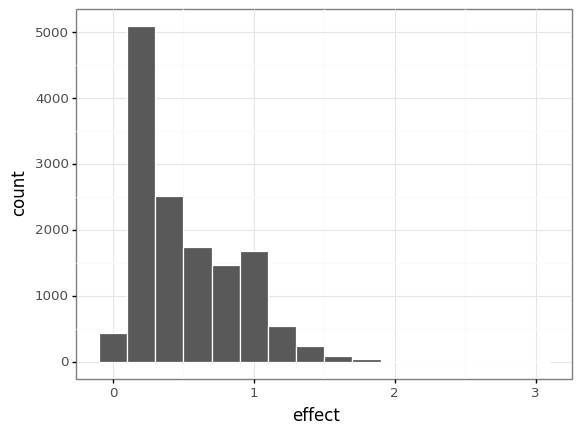

In [6]:
p = ggplot(data=muteffects, mapping=aes(x='effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

But it is hard to tell what is going on without looking at the log2effects instead: 

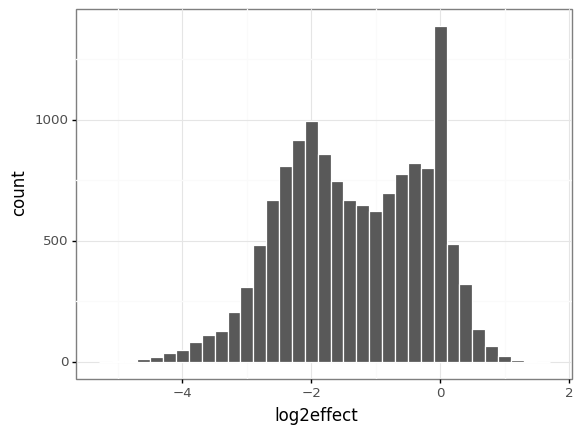

In [7]:
p = ggplot(data=muteffects, mapping=aes(x='log2effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

There are a few things about this distribution that we expect. There are two 'humps' in the distribution; one around 0 where mutations have small positive effects or small negative effects, and a larger one around -2 where mutations have very negative effects. Ideally, I would be able to remove the mutations making up the hump at -2. We can see that stop codon mutations make up part of this distribution around -2: 

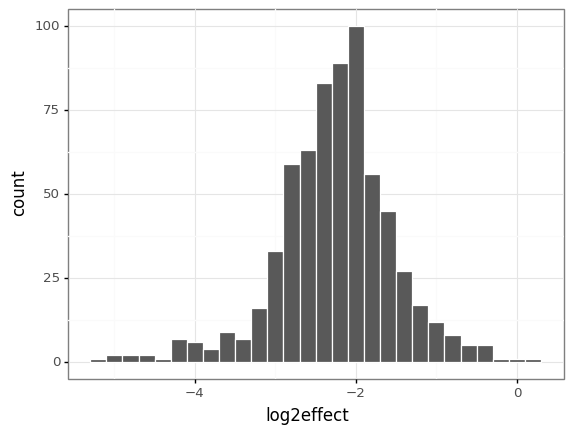

In [8]:
only_stops = muteffects.query("mutant == '*'")
p = ggplot(data=only_stops, mapping=aes(x='log2effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

We can compare the stop codon muteffect distribution above to a distribution of a different mutation, like alanine. We would expect the distribution for alanine to look more like the distribution for all mutations, and that is what it looks like: 

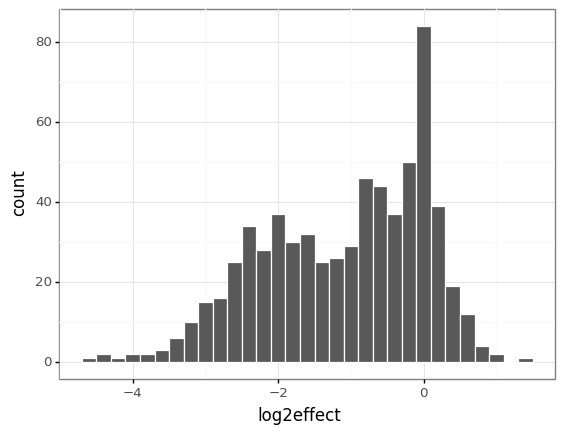

In [9]:
alanines = muteffects.query("mutant == 'A'")
p = ggplot(data=alanines, mapping=aes(x='log2effect')) + geom_histogram(color='white', binwidth=.2)
_ = p.draw()

As a first look at removing mutations, I looked at removing mutations at each site that have an effect lower than the effect of a stop mutations at that site. As Jesse pointed out, this might not be the best approach, since there is noise in each of the individual measurements, and the measurements for stop codons at some sites might result in too many or too little sites being removed at that site. 

In [10]:
# # Remove all mutations worse than stop codons at that site  
# cut_muteffects = pd.DataFrame()
# kept_muteffects = pd.DataFrame()
# for site in sites: 
#     stop_effect = muteffects.query('site == @site').query('mutant == "*"')['log2effect'].to_list()[0]
#     if cut_muteffects.empty: 
#         cut_muteffects = muteffects.query('site == @site').query('log2effect <= @stop_effect')
#     else: 
#         cut_muteffects = pd.concat([cut_muteffects, muteffects.query('site == @site').query('log2effect <= @stop_effect')])
#     if kept_muteffects.empty: 
#         kept_muteffects = muteffects.query('site == @site').query('log2effect > @stop_effect')
#     else: 
#         kept_muteffects = pd.concat([kept_muteffects, muteffects.query('site == @site').query('log2effect > @stop_effect')])

Instead I am going to look at removing all mutations from the library that have a muteffect below some quantile of stop codon muteffects. I am going to try some different quantiles. We can first visualize where on the distribution of mutantion effects and stop codon effects each quantile will land. We want a quantile not too far into the tail of stop codon effects that still remove much of the hump of very negative mutation effects around -2. 

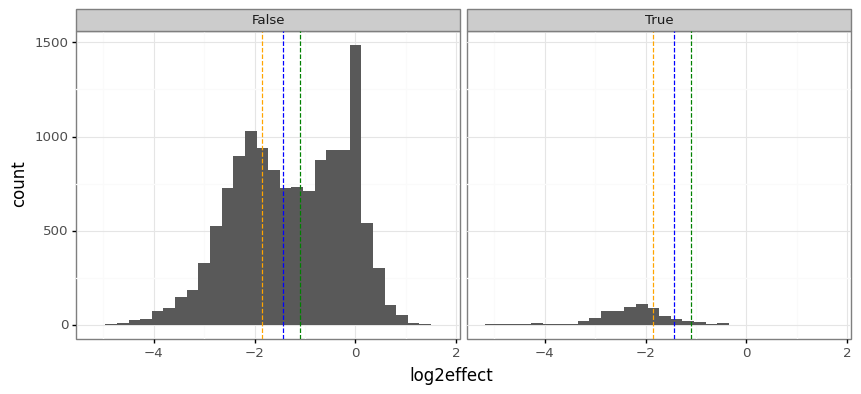

In [11]:
# Using some code from Jesse 
# get cutoff at each quantile
muteffects['is_stop'] = np.where(muteffects['mutant'] == '*', True, False)
quantiles = [0.75, 0.9, 0.95]
quantile_cutoffs = muteffects.query('is_stop')['log2effect'].quantile(quantiles).tolist()
# plot histograms with quantile cutoffs shown for both stop and non-stop mutations
p = (ggplot(muteffects) +
     aes('log2effect') +
     geom_histogram(bins=30) +
     facet_wrap('~ is_stop') +
     theme(figure_size=(10, 4))
    )
for quantile, cutoff, color in zip(quantiles, quantile_cutoffs, ['orange', 'blue', 'green']):
    p = p + geom_vline(xintercept=cutoff, color=color, linetype='dashed')
_ = p.draw()
# you may want to clean up appearance and perhaps add some code to label the different line colors for the quantile cutoffs

We can also look at how many stop mutations or total mutations are kept or cut depending on what quantile we use: 

In [12]:
n_above_cutoff = (
    pd.concat([muteffects.assign(quantile=quantile, quantile_cutoff=cutoff)
               for quantile, cutoff in zip(quantiles, quantile_cutoffs)])
    .assign(above_cutoff=lambda x: x['log2effect'] > x['quantile_cutoff'])
    .groupby(['quantile', 'is_stop', 'above_cutoff'])
    .aggregate(n_mutations=pd.NamedAgg('mutation', 'count'))
    )
display(n_above_cutoff)

n_mutations
quantile is_stop above_cutoff             
0.75     False   False                4498
                 True                 8742
         True    False                 496
                 True                  166
0.90     False   False                6052
                 True                 7188
         True    False                 595
                 True                   67
0.95     False   False                7084
                 True                 6156
         True    False                 628
                 True                   34

To get an idea of whether I might be cutting out too many mutations using this method, I am going to compare the mutations that I have kept and cut with each quantile cutoff with the amino acid frequencies of a natural sequence alignment. I am going to create a multiple sequence alignment (MSA) using some code from Hugh Haddox. It is made by downloading a [filtered sequence alignment](https://www.hiv.lanl.gov/content/sequence/NEWALIGN/align.html) from LANL. The filtering removes sequences that have major issues, such as frameshifts or low quality that prevent them from being aligned or translated. I will then make a MSA using these sequences in which all the amino acid sequences were stripped down to the HXB2 sequence (so, if they have insertions relative to HXB2, the insertions are removed). 

In [13]:
# Remove all mutations lower than some quantile of stop codon effects 
kept_mut_dfs = []
cut_mut_dfs = []
quantiles = [.75, .9, .95]
stop_mutants = muteffects.query('mutant == "*"')
stop_effects = stop_mutants['effect']
for quantile in quantiles: 
    cutoff = stop_effects.quantile(quantile)
    kept_muteffects = muteffects.query('effect >= @cutoff')
    cut_muteffects = muteffects.query('effect < @cutoff')
    kept_mut_dfs.append(kept_muteffects)
    cut_mut_dfs.append(cut_muteffects)

In [14]:
# Making cut down MSA from filtered alignment from LANL. Adapted from Hugh's code  

# Alignment files: changed to 2018
lanl_pro_f = './data/HIV1_FLT_2018_env_PRO.fasta'
lanl_dna_f = './data/HIV1_FLT_2018_env_DNA.fasta'

# Read in alignments
lanl_pro = alignutils.ReadInAlignment(lanl_pro_f)
lanl_dna = alignutils.ReadInAlignment(lanl_dna_f)
alignutils.AssertHeadersMatch(lanl_pro, lanl_dna)
print("The total number of sequences in the starting alignment is: %s"%(len(lanl_pro)))

# Filter sequences
assert lanl_pro[0][0] == lanl_dna[0][0] == 'B.FR.83.HXB2_LAI_IIIB_BRU.K03455', "Expected the first sequence to be HXB2"
len_hxb2_pro_with_gaps = len(lanl_pro[0][1])
disallowed_characters = ['#', 'X']
(filtered_lanl_pro, discarded_seqs) = alignutils.FilterAlignmentbyLengthandDisallowedCharacters(lanl_pro, disallowed_characters, len_hxb2_pro_with_gaps)
discarded_headers = [header for (header, seq) in discarded_seqs]
filtered_lanl_dna = [(header, seq) for (header, seq) in lanl_dna if header not in discarded_headers]
alignutils.AssertHeadersMatch(filtered_lanl_pro, filtered_lanl_dna)
print("The number of sequences filtered out of the alignment is: %s"%(len(discarded_seqs)))
print("The number of sequences remaining in the filtered alignment is: %s"%(len(filtered_lanl_pro)))

# Strip the alignment to only include columns that have a non-gap character in the HXB2 reference sequence.
# This step takes a long time, so read in from file if already there
lanl_pro_stripped_to_HXB2_outfile = '{0}/{1}'.format('data/', os.path.basename(lanl_pro_f).replace('.fasta', '_filtered_and_stripped_to_HXB2.fasta'))
if not os.path.isfile(lanl_pro_stripped_to_HXB2_outfile):
    lanl_pro_stripped_to_HXB2 = alignutils.StripGapsToFirstSequence(filtered_lanl_pro)
    lanl_dna_stripped_to_HXB2 = alignutils.StripGapsToFirstSequence(filtered_lanl_dna)
    assert len(lanl_pro_stripped_to_HXB2[0][1]) * 3.0 == len(lanl_dna_stripped_to_HXB2[0][1]) # compare the length of the HXB2 protein and DNA sequences
    print("Writing the filtered alignments stripped to the HXB2 sequence to the files: {0} and {1}".format(lanl_pro_stripped_to_HXB2_outfile, lanl_pro_stripped_to_HXB2_outfile.replace('PRO', 'DNA')))
    alignutils.WriteAlignmentToFASTA(lanl_pro_stripped_to_HXB2, lanl_pro_stripped_to_HXB2_outfile)
    alignutils.WriteAlignmentToFASTA(lanl_dna_stripped_to_HXB2, lanl_pro_stripped_to_HXB2_outfile.replace('PRO', 'DNA'))
else:
    print("Files of the filtered alignments stripped to the HXB2 sequence already exist.") # Reading them in from the files: {0} and {1}".format(lanl_pro_stripped_to_HXB2_outfile, lanl_pro_stripped_to_HXB2_outfile.replace('PRO', 'DNA'))
    lanl_pro_stripped_to_HXB2 = alignutils.ReadInAlignment(lanl_pro_stripped_to_HXB2_outfile)
    lanl_dna_stripped_to_HXB2 = alignutils.ReadInAlignment(lanl_pro_stripped_to_HXB2_outfile.replace('PRO', 'DNA'))
alignutils.AssertHeadersMatch(lanl_pro_stripped_to_HXB2, lanl_dna_stripped_to_HXB2)

The total number of sequences in the starting alignment is: 4072
The number of sequences filtered out of the alignment is: 367
The number of sequences remaining in the filtered alignment is: 3705
Files of the filtered alignments stripped to the HXB2 sequence already exist.


In [15]:
# Determine the number of sequences from each clade in the alignment 
a_pro = {}
a_dna = {}
a_pro['full'] = lanl_pro_stripped_to_HXB2
a_dna['full'] = lanl_dna_stripped_to_HXB2
clade_pattern = {}
clade_pattern['A'] = '^A[1-2]*\.' # A1. and A2.
clade_pattern['B'] = '^B\.'
clade_pattern['C'] = '^C\.'
clade_pattern['D'] = '^D\.'
clade_pattern['F'] = '^F[1-2]*\.' # F1. and F2.
clade_pattern['G'] = '^G\.'
clade_pattern['K'] = '^K\.'
print ("The total number of sequences in the curated alignment is {0}".format(len(a_pro['full'])))
print ("Here are the numbers of sequences per clade for the following set of group-M clades")
print ("clade\tnumber of sequences")
for clade in sorted(clade_pattern.keys()):
    a_pro[clade] = alignutils.FilterAlignmentByPatternInHeader(a_pro['full'], clade_pattern[clade])
    a_dna[clade] = alignutils.FilterAlignmentByPatternInHeader(a_dna['full'], clade_pattern[clade])
    print ("{0}\t{1}".format(clade, len(a_pro[clade])))

The total number of sequences in the curated alignment is 3705
Here are the numbers of sequences per clade for the following set of group-M clades
clade	number of sequences
A	213
B	1940
C	1299
D	111
F	55
G	78
K	3


In [16]:
# For each clade, make a protein and DNA alignment with a specified number of sequences
# (*n_seqs*, or fewer if there aren't *n_seqs* sequences for that clade)
# Caelan added option for 'all'
use_existing_grp_M = True
clades_to_sample = ['A', 'B', 'C', 'D', 'F', 'G', 'K']
all_seqs = True
clade_labels = []
identities = []
for clade in clades_to_sample:
    a_key = '{0}_subsampled'.format(clade)
    a_pro[a_key] = []
    pro_outfile = os.path.join('data/', 'clade_{0}_pro_alignment.fasta'.format(a_key))
    n_homolog_seqs = 0
    if all_seqs:
        n_seqs = len(a_pro[clade])
    elif len(a_pro[clade]) < n_seqs:
        n_seqs = len(a_pro[clade])
    if not os.path.isfile(pro_outfile) and use_existing_grp_M:      
        a_pro[a_key] += random.sample(a_pro[clade], n_seqs-n_homolog_seqs)
        pro_headers = [header for (header, seq) in a_pro[a_key]]
        a_dna[a_key] = sorted([(header, seq) for (header, seq) in a_dna['full'] if header in pro_headers])
        a_pro[a_key] = sorted(a_pro[a_key])
        print ("Generated alignments with {0} sequences for clade {1}".format(n_seqs, clade))
        alignutils.WriteAlignmentToFASTA(a_pro[a_key], pro_outfile)
        alignutils.WriteAlignmentToFASTA(a_dna[a_key], pro_outfile.replace('pro', 'dna'))
    else:
        a_pro[a_key] = alignutils.ReadInAlignment(pro_outfile)
        a_dna[a_key] = alignutils.ReadInAlignment(pro_outfile.replace('pro', 'dna'))
        print ("Clade {0} alignments with {1} sequences already exist".format(clade, len(a_pro[a_key])))
    assert len(a_pro[a_key]) == n_seqs
    alignutils.AssertHeadersMatch(a_pro[a_key], a_dna[a_key])
    
    # Determine the % identity of each seqeunce to BF520 using Hamming distance, but only looking at sites 
    # that were mutagenized in the deep mutational scanning and aligned to HXB2
    alignment = SeqIO.parse(f"data/clade_{a_key}_pro_alignment.fasta", 'fasta')
    for record in alignment: 
        aa_sequence = record.seq
        mutagenized_sequence = ''.join([aa_sequence[int(i)-1] for i in aligned_mutagenized_HXB2_sites])
        dist = distance.hamming(mutagenized_BF520_sequence, mutagenized_sequence)/len(mutagenized_BF520_sequence)
        clade_labels.append(a_key)
        identities.append(1 - dist)

Clade A alignments with 213 sequences already exist
Clade B alignments with 1940 sequences already exist
Clade C alignments with 1299 sequences already exist
Clade D alignments with 111 sequences already exist
Clade F alignments with 55 sequences already exist
Clade G alignments with 78 sequences already exist
Clade K alignments with 3 sequences already exist


Here is a plot of the percent identity of each sequence in the alignment with BF520 at the sites mutagenized in the deep mutational scanning and aligned to HXB2, calculated by Hamming distance and colored by which clade the sequence is from: 

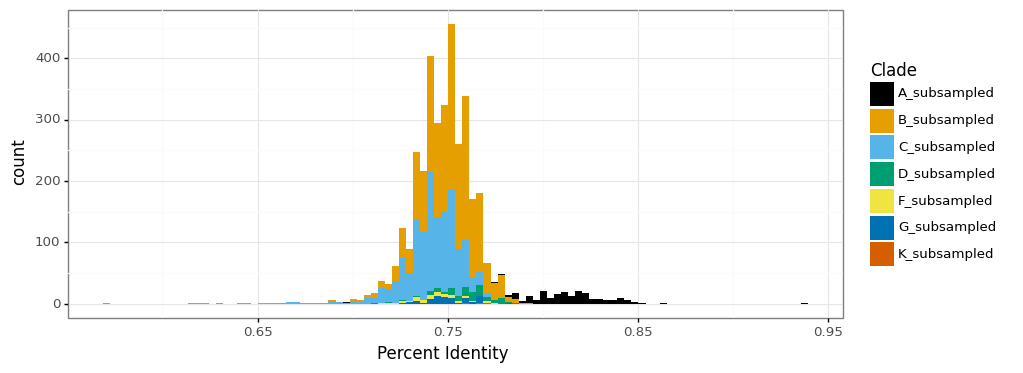

In [17]:
identities_df = pd.DataFrame({"Clade": clade_labels,
                           "Percent Identity": identities})

p = (ggplot(identities_df) +
     aes(x='Percent Identity', fill='Clade') +
     geom_histogram(bins=100) +
     theme(figure_size=(10, 4)) +
    scale_fill_manual(COLOR_BLIND_PALETTE)
    )
_ = p.draw()

Since none of the other clades seem to be as similar to BF520 in amino acid sequence as clade A, we will take a closer look at clade A for adding mutations back to the library based on natural sequence variation. 

For the full alignment and the clade A alignment, I am going to count the frequency of amino acids at every HXB2 position in the MSA, and then compare the mutations present with the mutations that I kept and removed from the library. I will count amino acids as present or not present in the MSA using different cutoffs for the counts (so for MSA-cutoff of 0, there must be more than 0 counts of an amino acid to be present at a site, for an MSA-cutoff of 5, there must be more than 5 counts of an amino acid to be present at a site, etc). I'll then look at the percentage of mutations that are present in the library that are not in the MSA, as well as how many mutations in the MSA are not in the library. 

In [18]:
# Read the alignments 
full_alignment = AlignIO.read("data/HIV1_FLT_2018_env_PRO_filtered_and_stripped_to_HXB2.fasta", "fasta")
A_alignment = AlignIO.read('data/clade_A_subsampled_pro_alignment.fasta', 'fasta')

# Generate dictionaries for each MSA containing the counts of each amino acid at each site, ignoring deletions
counts_dicts = []
for align in [full_alignment, A_alignment]: 
    counts_dict = {}
    for record in align: 
        sequence = record.seq
        for i, AA in enumerate(sequence):
            if AA != '-':
                if str(i+1) in HXB2_to_BF520: 
                    if i+1 not in counts_dict:
                        counts_dict[i+1] = {}
                    if AA not in counts_dict[i+1]:
                        counts_dict[i+1][AA] = 1 
                    else: 
                        counts_dict[i+1][AA] += 1
    counts_dicts.append(counts_dict)

# Generate a dataframe comparing the MSA with the libraries                    
names = []
lib_muts = []
nat_muts = []
extras = []
mis_nats = []
natural_counts_cutoffs = [0, 1, 3]
verbose = False
dfs=[]
for (counts_dict, name) in zip(counts_dicts, ['full', 'clade_A']):
    df=muteffects.copy()
    df['alignment'] = name
    for natural_counts_cutoff in natural_counts_cutoffs: 
        for i, quantile in enumerate(quantiles): 
            kept_muteffects = kept_mut_dfs[i]
            library_mutations = 0
            natural_mutations = 0
            extras_kept = 0 
            missing_naturals = 0
            kept_natural_mutations_list = {}
            for site in kept_muteffects['site'].unique():
                mutants = kept_muteffects.query('site == @site')
                kept_mutations = mutants['mutant'].unique()
                library_mutations += len(kept_mutations)
                try: 
                    site = int(site)
                except:
                    kept_natural_mutations_list[str(site)] = []
                if isinstance(site, int):
                    natural_counts = counts_dict[site]
                    kept_natural_aas = []
                    for aa in natural_counts: 
                        if natural_counts[aa] > natural_counts_cutoff: 
                            natural_mutations += 1
                            kept_natural_aas.append(aa)
                            if str(site) not in kept_natural_mutations_list:
                                kept_natural_mutations_list[str(site)] = [aa]
                            else: 
                                kept_natural_mutations_list[str(site)].append(aa)
                    missing_aas = []
                    for aa in kept_natural_aas:
                        if aa not in kept_mutations:
                            missing_aas.append(aa)
                            missing_naturals += 1
                    for aa in kept_mutations:
                        if aa not in kept_natural_aas: 
                            extras_kept += 1
            names.append(f"{quantile}_{name}_{natural_counts_cutoff}")
            lib_muts.append(library_mutations)
            nat_muts.append(natural_mutations)
            extras.append(extras_kept)
            mis_nats.append(missing_naturals)

        df[natural_counts_cutoff] = [x[1] in kept_natural_mutations_list[x[0]] for x in zip(muteffects['site'], muteffects['mutant'])]    
    dfs.append(df)

muteffects_walignments=pd.concat(dfs)
muteffects_walignments.fillna(value=False, inplace=True)

summary = pd.DataFrame({'Quantile_MSA_cutoff': names,
                       'Mutations in library': lib_muts,
                       'Mutations in MSA': nat_muts,
                       '# muts in library not in MSA': extras,
                       '# muts in MSA not in library': mis_nats})
display(summary)

,Quantile_MSA_cutoff,Mutations in library,Mutations in MSA,# muts in library not in MSA,# muts in MSA not in library
0,0.75_full_0,8908,6949,3386,1522
1,0.9_full_0,7255,6949,2398,2183
2,0.95_full_0,6190,6949,1820,2668
3,0.75_full_1,8908,5338,4309,834
4,0.9_full_1,7255,5338,3082,1256
5,0.95_full_1,6190,5338,2376,1613
6,0.75_full_3,8908,4210,5038,435
7,0.9_full_3,7255,4210,3663,709
8,0.95_full_3,6190,4210,2836,945
9,0.75_clade_A_0,8908,2952,6051,190


Everything looks about as expected. As more mutations are kept in the library, there are more mutations in the library that are not in the MSA and less mutations in the MSA that are not present in the lirbary. There are more mutations present in the full alignment than the clade A only alignment. 

I am also going to visualize mutations present in the MSA present above each natural sequence cutoff as a histogram, so we can see how they compare to the distribution of the effects of all mutations: 

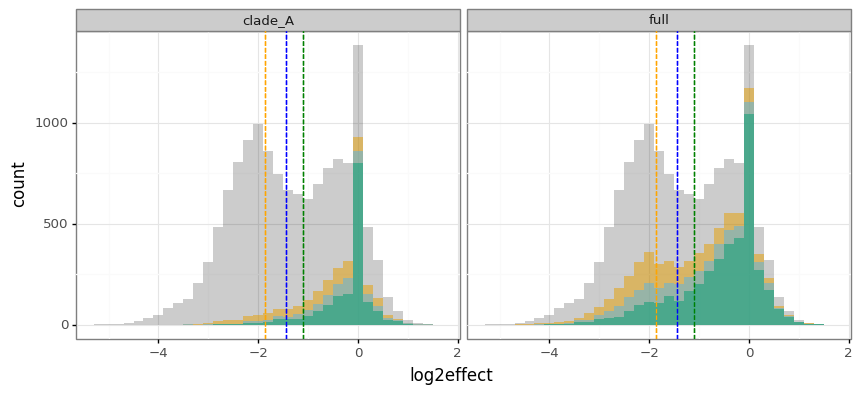

In [19]:
# plot histograms with quantile cutoffs shown for both stop and non-stop mutations
color_iter=iter(COLOR_BLIND_PALETTE)
p = (ggplot(data=muteffects, mapping=aes(x='log2effect')) +
    geom_histogram(fill=next(color_iter), binwidth=.2, alpha=.2) +
    facet_wrap('alignment') +
    theme(figure_size=(10, 4)))
for cutoff in natural_counts_cutoffs:
    p = p + geom_histogram(data=muteffects_walignments[muteffects_walignments[cutoff]], mapping=aes(x='log2effect'), binwidth=.2, alpha=.5, fill=next(color_iter))
    
    for quantile, cutoff, color in zip(quantiles, quantile_cutoffs, ['orange', 'blue', 'green']):
        p = p + geom_vline(xintercept=cutoff, color=color, linetype='dashed')
_ = p.draw()

In this plot, the greyed out distribution is the distribution of the effects of all mutations, while each colored distribution is the distribution of the effects of mutations in the MSA that are present above different count cutoffs (Yellow>0, Blue>1, Green>3). The verical colored bars still represent the cutoff points for different quantiles of stop codon effects (Yellow=.75, Blue=.9, Green=.95). 

The distribution of the effects of mutations from the full alignment of all subtypes of Env has a distribution not too unlike the deep mutational scanning data, where there is a clear hump of very negative mutations. This hump of very negative mutations is much less prevalent in the effects of mutations from the alignment of only clade A Env. This makes me want to add back mutations present in the clade A alignment rather than the full alignment, also considering the diversity of HIV sequences and that we know divergent Envs have shifts in the effects of mutations at many sites. When a mutation is required to be present at least more than once in the clade A alignment to be counted as present, it cuts about 800 mutations out of the total, and cuts them from all over the distribution (yellow-->blue). When a mutation must be present more than three times, about 500 more mutations are removed, again from all over the distribution (blue-->green). Therefore, I am not really sure if having a more stringent cutoff is really doing much other than removing rarer sequences. This makes me want to add back mutations that present more than one time in the clade A alignemnt, just to be more likely to get rid of mutations in the alignment that are sequencing errors. This would be adding back the blue histogram in the above left plot. 

Jesse brought up the good point that many people in the HIV field are mostly interested in broadly neutralizing antibodies and how they interact with HIV strains from every clade. This makes it more attractive to actually include the mutations from the full natural sequence alignemnt, even if more of them were negative in the previous deep mutational scan than just the mutations from the clade A alignment. In the future, I think creating libraries in many strains of Env will be the best solution to this problem, but for now, including more mutations in the first BF520 library seems reasonable.  

The selection of the stop codon effect quantile feels arbitrary, but I want to use .95 (green vertical line), to give variants in the library with multiple mutations better chances of being alive. .95 seems to be right on the verge of cutting into the hump of mutations with moderate effects (and probably is removing many of these mutations), but I think that having a library with mostly alive variants is important for what I want to do. 

I will now make a dataframe containing mutations with effects above the chosen stop codon effect quantile (.95) or present in the full natural sequence alignment with a frequency greater than one. 

10175 mutations are in the library
These mutations are across 658 sites
Here is a distribution of the log2effects of these mutations:


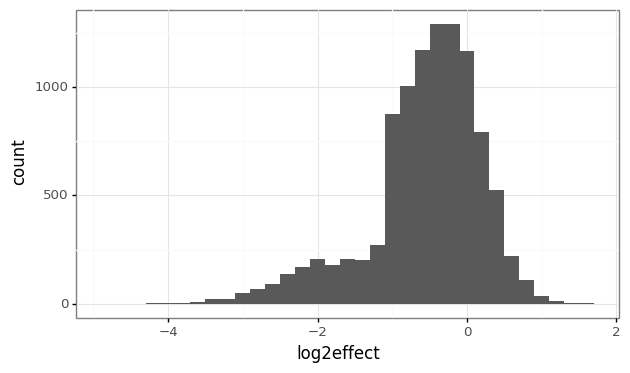

<ggplot: (1431461466633)>

In [20]:
# I should probably change this list of dataframes into a dictionary 
quantile_95_muts = kept_mut_dfs[2].copy()
wt_muts = muteffects_walignments[muteffects_walignments[1]].query('alignment == "full"')
wt_muts.drop(columns=['alignment', 0, 1, 3], inplace=True)
quantile_95_muts['mut_type'] = 'dms_tolerated_mutations'
wt_muts['mut_type'] = 'natural_sequence_mutations'
library_mutations = pd.concat([quantile_95_muts, wt_muts])
library_df_w_wts = library_mutations.query('is_stop==False')
library_df = library_df_w_wts.query('log2effect!=0')
print(f"{len(library_df)} mutations are in the library")
print(f"These mutations are across {len(library_df['site'].unique().tolist())} sites")
print(f"Here is a distribution of the log2effects of these mutations:")

(ggplot(data=library_df, mapping=aes(x='log2effect')) +
    geom_histogram(binwidth=.2) +
    theme(figure_size=(7, 4)))

We could also add back stop codons at some random sites to have as controls for data analysis later. Not really sure what the best frequency would be, but I think just a couple or a handful of sites would do. 

In [21]:
# Add back some stop codons
# Going to arbitrarily pick sites 100, 200, and 300 
stops = muteffects.query('site in ["100", "200", "300"]').query('mutant == "*"')
stops['mut_type'] = 'stop'
library_df = pd.concat([library_df, stops])

In order to try to add back synonymous codons at sites we might be very interested in, I am going to use the [Antigenic Atlas of HIV-1 escape to broadly neutralizing antibodies](https://www.sciencedirect.com/science/article/pii/S107476131830565X) to try to curate a list of BF520 sites that may be important for antibody escape. Most of the mutational antigenic profiling done in that paper was done using the BG505 strain rather than BF520, but the sites of escape to the antibody PGT151 were very similar in BG505 and BF520, as shown in that paper. Sites that were significant sites of escape to antibodies in the BG505 strain are likely interesting sites for BF520 escape to antibodies. Therefore, we want synonymous codons at these sites in order to be able to look at potential synonymous codons effects on escape later. 

In addition to these sites of escape, I am going to add back some mutations across sites of interest for some different antibody epitopes on HIV Env. I got the list of these sites from Adam Dingnes; the lists are curated based on antibody escape, close contacts in crystal structures, and previous HIV Env literature. 

Below, I use a list of the significant sites of escape to each antibody in the BG505 strain to choose sites in BF520 to have two codon mutations per amino acid mutation. 

In [22]:
# Look at sites of escape from antigenic atlas paper as sites for synonymous codons 
# Listing these out here by antibody for future reference 
all_escape_sites = [] 
escape_sites = {'PGT121': ['332', '327', '415', '330', '325', 
                         '408', '406', '428', '323', '443', 
                         '419', '326', '471', '380'], 
                'VRC01': ['279', '326', '369', '197', '209'],
                '101074': ['325', '332', '327', '415', '330', 
                           '204', '441', '323'],
                '3BNC117': ['207', '304', '197', '318', '471', 
                            '279', '119', '308', '209', '206', 
                            '182', '120', '204', '369', '274'],
                'VRC34': ['88', '85', '524', '512', '513', '515', 
                          '516', '229', '514', '243', '518', '629'], 
                'PG9': ['160', '171', '169', '162'], 
                'PGT151': ['611', '512', '637', '514', '647', '322a', 
                           '318', '327', '224', '629', '142'],
                'PGT145':  ['166', '160', '121', '169', '162', 
                            '127', '124', '315', '123', '202', 
                            '197', '312', '203'],
                '10E8': ['671', '673', '672', '683', '680', '676', 
                         '643', '682', '609'],
                '118': ['304', '119', '207', '318']}

# sites of interest across different epitopes 
# listing these out by epitope for future reference 
CD4bs_sites = ['113','119', '120', '121', "195", "196",'197', 
               '198', '199', '206','207', '208', '209', '275', 
               '276', '277', '278', '279', '280', '281', '282', 
               '283', '304', '305', '306', '307', '308', '309', 
               '310', '311', '312', '313', '314', '315', '316', 
               '317', '318', '319', '320', '326', '362', '363', 
               '364', '365', '366', '367', '368', '369', '370', 
               '371', '372', '373', '427', '428', '429', '430', 
               '455', '456', '457', '458', '459', '460', '461', 
               '471']
V3_sites = ['323', '324', '325', '326', '327', '328', '329', 
            '330', '331', '332', '333', '334', '415', '416', 
            '417', '441']
FP_sites = ['229', '230', '231', '241', '242', '243', '244', 
            '245', '246', '512', '513', '514', '515', '516', 
            '517', '518', '519', '520', '521', '522', '523', 
            '524', '611', '612', '613', '637', '638', '639', 
            '640', '641', '642', '643', '644', '647', '80', 
            '81', '82', '83', '84', '85', '86', '87', '88', 
            '89', '90']
V2_sites = ["119", "120", "121", '122', '123', '124', '127', 
            '156', '157', '158', '159', '160', '161', '162', 
            '163', '164', '165', '166', '167', '168', '169', 
            '170', '171', '172', '173', '199', '200', '201', 
            '202', '203', '204', '312', '313', '314', '315']
MPER_sites = ['671', '672', '673', '674', '675', '676', '677', 
              '678', '679', '680', '681', '682', '683']

for antibody in escape_sites: 
    for site in escape_sites[antibody]: 
        if site not in all_escape_sites: 
            all_escape_sites.append(site)
print(f"Number of signifcant sites of escape: {len(all_escape_sites)}")
library_escape_df = library_df.query('site in @all_escape_sites')
library_escape_df = library_escape_df.query('mutant not in ["W", "M", "*"]')
# aas with two codons: ['F', 'Y', 'C', 'H', 'Q', 'N', 'K', 'D', 'E']
# aas with three codons: ['I']
# aas with four codons: ['V', 'P', 'T', 'A', 'G']
# aas with six codons: ['L', 'S', 'R']
syn_dict = {'F': 2,
           'Y': 2,
           'C': 2, 
           'H': 2, 
           'Q': 2,
           'N': 2,
           'K': 2,
           'D': 2,
           'E': 2,
           'I': 3,
           'V': 3,
           'P': 3,
           'T': 3,
           'A': 3,
           'G': 3,
           'L': 3,
           'S': 3,
           'R': 3}
print(f"Number of aa mutations at escape sites with more than one codon: {len(library_escape_df)}")
syn_escape_muts_to_make = (sum([syn_dict[x] for x in library_escape_df['mutant'].tolist()]) 
                           - len(library_escape_df))
print('Number of extra synonymous mutations at those sites making a max of 3 codon mutations per aa:')
print((syn_escape_muts_to_make))

Number of signifcant sites of escape: 69
Number of aa mutations at escape sites with more than one codon: 1053
Number of extra synonymous mutations at those sites making a max of 3 codon mutations per aa:
1647


In [23]:
mutations_per_pool = 12000
extra_mutations = mutations_per_pool - len(library_df)
extra_mutations -= syn_escape_muts_to_make
print(f"We still have {extra_mutations} more codon mutations to add to the library")

We still have 175 more codon mutations to add to the library


In [24]:
interesting_sites = set(CD4bs_sites + V3_sites + FP_sites + V2_sites + MPER_sites)
unadded_sites = []
for site in interesting_sites: 
    if site not in all_escape_sites: 
        unadded_sites.append(site)
print(f"Interesting sites not in escape sites: {len(unadded_sites)}")
interesting_sites_df = (library_df.query('site in @unadded_sites')
                                  .query('mutant not in ["W", "M", "*"]'))
print(f"Number of mutations with more than one codon at these sites: {len(interesting_sites_df)}")
print('Number of extra synonymous mutations at those sites making a max of 3 codon mutations per aa:')
interesting_syn_mutations = (sum([syn_dict[x] for x in interesting_sites_df['mutant'].tolist()]) 
                           - len(interesting_sites_df))
print(interesting_syn_mutations)
extra_mutations -= interesting_syn_mutations
print(f"We have {extra_mutations} more mutations to add to the library")
#print(f"Picking {extra_mutations} random mutations from these to have two codons...")
#random_interesting_sites_df = interesting_sites_df.sample(n=extra_mutations)

Interesting sites not in escape sites: 107
Number of mutations with more than one codon at these sites: 1610
Number of extra synonymous mutations at those sites making a max of 3 codon mutations per aa:
2490
We have -2315 more mutations to add to the library


Adding one codon for each would add 722 more codon mutations to the library. I can then fill out the rest of the extra primers with random pick of mutations to have an extra codon mutation:

In [25]:
# Concatenate the dataframes
library_escape_df['num_codons']= library_escape_df.apply(lambda x: syn_dict[x['mutant']], axis=1)
interesting_sites_df['num_codons'] = interesting_sites_df.apply(lambda x: syn_dict[x['mutant']], axis=1)
interesting_mutations = interesting_sites_df['mutation'].tolist()
lib_escape_mutations = library_escape_df['mutation'].tolist()
library_no_syn = (library_df.query('mutation not in @lib_escape_mutations')
                            .query('mutation not in @interesting_mutations'))
if extra_mutations > 0: 
    print(f"Picking {extra_mutations} random mutations remaining in the library to have two codons...")
    random_sites_df = library_no_syn.query('mutant not in ["W", "M", "*"]').sample(n=extra_mutations)
    random_sites_df['num_codons'] = 2
    random_mutations = random_sites_df['mutation'].tolist()
else: 
    random_sites_df = pd.DataFrame()
    random_mutations = []
remaining_lib = library_no_syn.query('mutation not in @random_mutations').copy()
remaining_lib['num_codons'] = 1
final_library_df = pd.concat([library_escape_df, interesting_sites_df, random_sites_df, remaining_lib])

In [26]:
# Make sure the right number of mutations will be made 
print('Total number of codon mutations:')
print(sum(final_library_df['num_codons'].tolist()))

Total number of codon mutations:
14315


In [27]:
# Convert site numbering back to BF520 numbering and then save the library in a csv file
BF520_sites = []
for site in final_library_df['site'].tolist(): 
    BF520_sites.append(HXB2_to_BF520[site])
final_library_df['site'] = BF520_sites
if overwrite_results:
    final_library_df.to_csv('results/library_df.csv')

After initial attempts to produce a mutant library with the primers designed above and ordered from Twist, it became apparent that the yield of primers received from Twist for their primer pools is not enough to perform PCR library mutagenesis using our protocol. Therefore, I am redesigning the primers to be ordered from IDT. Since each primer coding for a mutation synonymous to one already being made will now cost extra to be produced, and we do not really expect there to be synonymous codon effects in the codon optimized lentivirus construct, I am greatly limiting the number of synonymous mutations being made. 100 wildytpe synonymous mutations will be in the library, along with 100 synoymous mutations to mutations being made at sites previously found to be sites of antibody escape mutations. 

In [28]:
wts = library_df_w_wts.query('log2effect==0')
syn_mutations = 100
wt_syn_mutations_df = wts.query('mutant not in ["W", "M", "*"]').sample(n=syn_mutations)
wt_syn_mutations_df['num_codons'] = 1
wt_syn_mutations = wt_syn_mutations_df['mutation'].tolist()
library_escape_df['num_codons']= 2
library_escape_df = library_escape_df.sample(n=syn_mutations)
escape_syn_mutations = library_escape_df['mutation'].tolist()
remaining_lib = (library_df.query('mutation not in @wt_syn_mutations')
                           .query('mutation not in @escape_syn_mutations'))
remaining_lib['num_codons'] = 1
IDT_library_df = pd.concat([wt_syn_mutations_df, library_escape_df, remaining_lib])
print('Total codon mutations in the IDT library:')
print(sum(IDT_library_df['num_codons'].tolist()))
BF520_sites = []
for site in IDT_library_df['site'].tolist(): 
    BF520_sites.append(HXB2_to_BF520[site])
IDT_library_df['site'] = BF520_sites
if overwrite_results:
    (IDT_library_df.drop(['mutation_conversion'], axis=1)
     .drop_duplicates(subset='mutation')
     .to_csv('results/IDT_library_df.csv'))
# make file to convert output format for later analysis
IDT_library_df.to_csv('results/conversion.csv')

Total codon mutations in the IDT library:
10325


7107 mutations are in the library
These mutations are across 658 sites
Here is a distribution of the log2effects of these mutations:


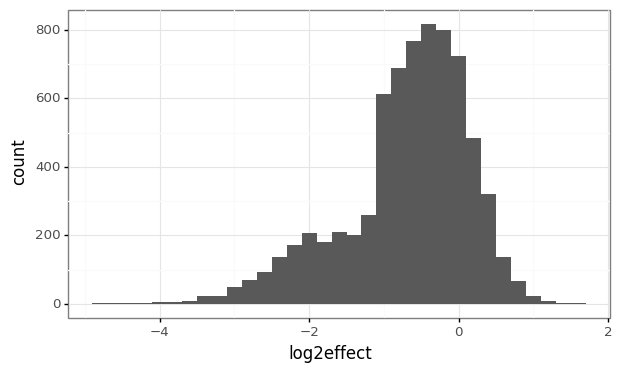

<ggplot: (1431462528589)>

In [29]:
# I should probably change this list of dataframes into a dictionary 
quantile_95_muts = kept_mut_dfs[2].copy()
wt_muts = muteffects_walignments[muteffects_walignments[1]].query('alignment == "full"')
wt_muts.drop(columns=['alignment', 0, 1, 3], inplace=True)
quantile_95_muts['mut_type'] = 'dms_tolerated_mutations'
wt_muts['mut_type'] = 'natural_sequence_mutations'
library_mutations = pd.concat([quantile_95_muts, wt_muts]).drop_duplicates("mutation")
library_df_w_wts = library_mutations.query('is_stop==False')
library_df = library_df_w_wts.query('log2effect!=0')
print(f"{len(library_df)} mutations are in the library")
print(f"These mutations are across {len(library_df['site'].unique().tolist())} sites")
print(f"Here is a distribution of the log2effects of these mutations:")

(ggplot(data=library_df, mapping=aes(x='log2effect')) +
    geom_histogram(binwidth=.2) +
    theme(figure_size=(7, 4)))

The following cells produce figures that are later used in the paper

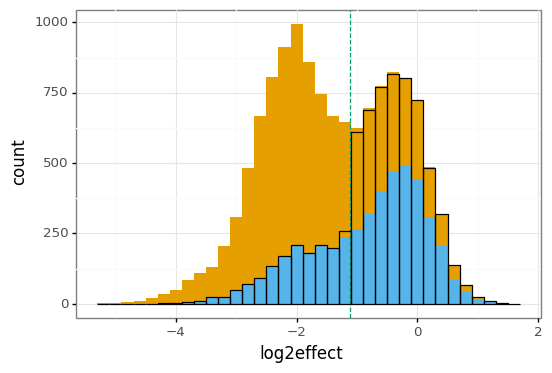

In [30]:
# Figures for paper
color_iter=iter(COLOR_BLIND_PALETTE)
next(color_iter)
plot_data = muteffects.query('log2effect!=0')
p = (ggplot(data=plot_data, mapping=aes(x='log2effect')) +
    geom_histogram(fill=next(color_iter), binwidth=.2, alpha=1) +
    theme(figure_size=(6, 4)))
plot_data = wt_muts.query('log2effect!=0')
p = p + geom_histogram(data=plot_data, mapping=aes(x='log2effect'), binwidth=.2, alpha=1, fill=next(color_iter))
p = p + geom_vline(xintercept=quantile_cutoffs[2], color=next(color_iter), linetype='dashed')
p = p + geom_histogram(data=library_df, mapping=aes(x='log2effect'), binwidth=.2, alpha=0, colour='black')
_ = p.draw()

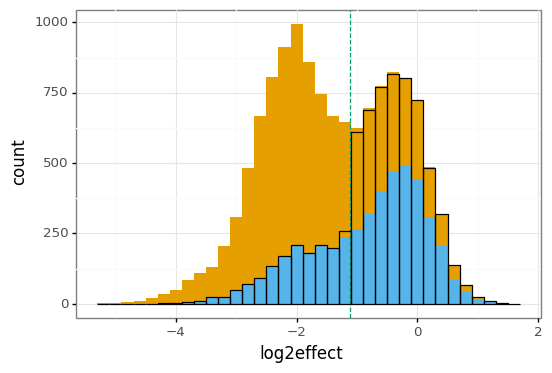

In [31]:
# Figures for paper
color_iter=iter(COLOR_BLIND_PALETTE)
next(color_iter)
plot_data = muteffects.query('log2effect!=0')
p = (ggplot(data=plot_data, mapping=aes(x='log2effect')) +
    geom_histogram(fill=next(color_iter), binwidth=.2, alpha=1) +
    theme(figure_size=(6, 4)))
plot_data = wt_muts.query('log2effect!=0')
p = p + geom_histogram(data=plot_data, mapping=aes(x='log2effect'), binwidth=.2, alpha=1, fill=next(color_iter))
p = p + geom_vline(xintercept=quantile_cutoffs[2], color=next(color_iter), linetype='dashed')
p = p + geom_histogram(data=library_df, mapping=aes(x='log2effect'), binwidth=.2, alpha=0, colour='black')
_ = p.draw()

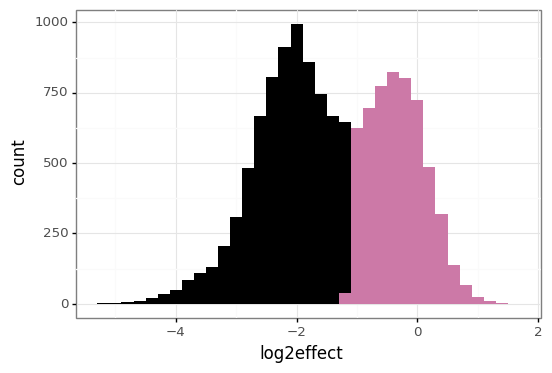

In [32]:
color_iter=iter(COLOR_BLIND_PALETTE)
plot_data = muteffects.query('log2effect!=0')
p = (ggplot(data=plot_data, mapping=aes(x='log2effect')) +
    geom_histogram(fill=next(color_iter), binwidth=.2, alpha=1) +
    theme(figure_size=(6, 4)))
cutoff = quantile_cutoffs[2]
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
plot_data = muteffects.query('log2effect!=0').query('log2effect>=@cutoff')
p = p + geom_histogram(data=plot_data, mapping=aes(x='log2effect'), binwidth=.2, alpha=1, fill=next(color_iter))
_ = p.draw()

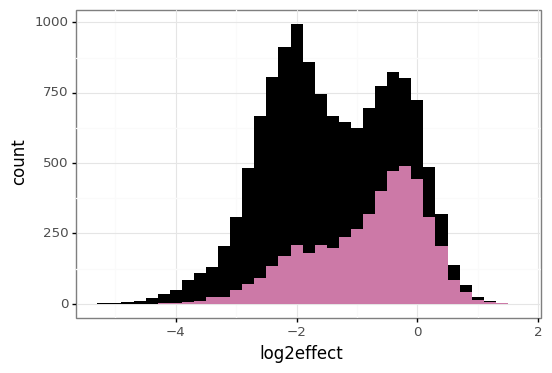

In [33]:
color_iter=iter(COLOR_BLIND_PALETTE)
plot_data = muteffects.query('log2effect!=0')
p = (ggplot(data=plot_data, mapping=aes(x='log2effect')) +
    geom_histogram(fill=next(color_iter), binwidth=.2, alpha=1) +
    theme(figure_size=(6, 4)))
cutoff = quantile_cutoffs[2]
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
plot_data = wt_muts.query('log2effect!=0')
p = p + geom_histogram(data=plot_data, mapping=aes(x='log2effect'), binwidth=.2, alpha=1, fill=next(color_iter))
_ = p.draw()

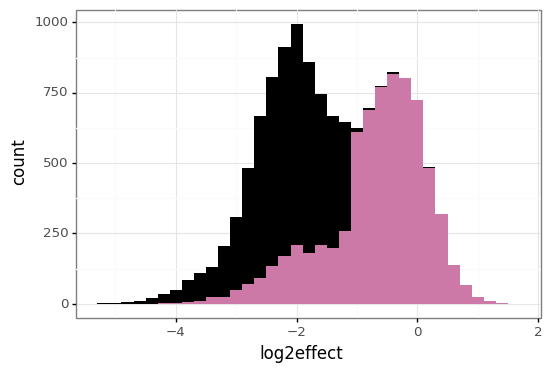

In [34]:
color_iter=iter(COLOR_BLIND_PALETTE)
plot_data = muteffects.query('log2effect!=0')
p = (ggplot(data=plot_data, mapping=aes(x='log2effect')) +
    geom_histogram(fill=next(color_iter), binwidth=.2, alpha=1) +
    theme(figure_size=(6, 4)))
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
next(color_iter)
plot_data = library_df
p = p + geom_histogram(data=plot_data, mapping=aes(x='log2effect'), binwidth=.2, alpha=1, fill=next(color_iter))
_ = p.draw()

The following cells write some csv files containing information about the frequency of mutations relative to BF520 in natural HIV sequences for later use.

In [37]:
muteffects_walignments.to_csv('results/natural_sequence_data.csv')

In [38]:
sites = []
mutants = []
counts = []
for reference_site in counts_dicts[0]:
    for mutant in counts_dicts[0][reference_site]:
        sites.append(reference_site)
        mutants.append(mutant)
        counts.append(counts_dicts[0][reference_site][mutant])
data = pd.DataFrame({'reference_site': sites,
                   'mutant': mutants,
                   'count': counts})
data.to_csv('results/natural_sequence_mutation_counts.csv', index=False)

,reference_site,mutant,count
0,31,T,742
1,31,A,1077
2,31,V,500
3,31,E,275
4,31,G,250
...,...,...,...
6944,702,F,171
6945,702,V,13
6946,702,S,1
6947,702,P,3
